# Initializing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import lightgbm as lgb

In [20]:
processed_data_dir = Path("../data/processed")

df = pd.read_csv(processed_data_dir / "kzt_exchange_rates_processed_ml.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.dropna(inplace=True)

In [21]:
features = [
    'lag_1', 
    'lag_2', 
    'lag_7',
    'lag_30',
    'lag_1_diff', 
    'lag_2_diff', 
    'lag_7_diff', 
    'lag_30_diff',
    'rolling_3', 
    'rolling_7', 
    'rolling_30',
    'weekday_sin', 
    'weekday_cos', 
    'month_sin', 
    'month_cos'
    ]
target = 'exchange_rate'

# Forecasting the current day given the past

In [22]:
X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

# Support Vector Regression

In [ ]:
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

svr_params = {
    'svr__kernel': ['rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 50, 100],
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2],
    'svr__gamma': ['scale', 'auto']
}

svr_search = RandomizedSearchCV(
    svr_pipe,
    param_distributions=svr_params,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

svr_search.fit(X_train, y_train)

best_svr = svr_search.best_estimator_
print("Best SVR:", svr_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=poly; total time=   1.0s[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=poly; total time=   1.0s

[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=poly; total time=   1.0s
[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=poly; total time=   1.0s
[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=poly; total time=   1.0s
[CV] END svr__C=10, svr__epsilon=0.01, svr__gamma=auto, svr__kernel=sigmoid; total time=   1.2s
[CV] END svr__C=10, svr__epsilon=0.01, svr__gamma=auto, svr__kernel=sigmoid; total time=   1.2s
[CV] END svr__C=10, svr__epsilon=0.01, svr__gamma=auto, svr__kernel=sigmoid; total time=   1.2s
[CV] END svr__C=10, svr__epsilon=0.01, svr__gamma=auto, svr__kernel=sigmoid; total time=   1.2s
[CV] END svr__C=10, svr__epsilon=0.01, svr__gamma=auto, svr__kernel=sigmoid; total t

In [35]:
svr_search.best_params_

{'svr__kernel': 'poly',
 'svr__gamma': 'scale',
 'svr__epsilon': 0.01,
 'svr__C': 100}

# Random Forest

In [24]:
rf_pipe = Pipeline([
    ("rf", RandomForestRegressor(random_state=42))
])

rf_params = {
    'rf__n_estimators': [200, 300, 500],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_params,
    n_iter=25,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("Best RF:", rf_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total time=   0.5s
[CV] END rf__max_depth=20, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=300; total time=   0.5s
[CV] END rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=500; total time=   0.6s
[CV] END rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=500; total time=   0.7s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total time=   0.7s
[CV] END rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=500; total time=   0.8s
[CV] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, 

# AdaBoost

In [25]:
ada_pipe = Pipeline([
    ("ada", AdaBoostRegressor(random_state=42))
])

ada_params = {
    'ada__n_estimators': [50, 100, 200, 400],
    'ada__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
}

ada_search = RandomizedSearchCV(
    ada_pipe,
    param_distributions=ada_params,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

ada_search.fit(X_train, y_train)

best_ada = ada_search.best_estimator_
print("Best AdaBoost:", ada_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....ada__learning_rate=0.001, ada__n_estimators=50; total time=   0.1s
[CV] END .....ada__learning_rate=0.001, ada__n_estimators=50; total time=   0.2s
[CV] END ....ada__learning_rate=0.001, ada__n_estimators=100; total time=   0.3s
[CV] END .....ada__learning_rate=0.001, ada__n_estimators=50; total time=   0.3s
[CV] END ....ada__learning_rate=0.001, ada__n_estimators=100; total time=   0.5s
[CV] END .....ada__learning_rate=0.001, ada__n_estimators=50; total time=   0.5s
[CV] END ......ada__learning_rate=0.01, ada__n_estimators=50; total time=   0.1s
[CV] END ....ada__learning_rate=0.001, ada__n_estimators=200; total time=   0.6s
[CV] END .....ada__learning_rate=0.001, ada__n_estimators=50; total time=   0.6s
[CV] END ....ada__learning_rate=0.001, ada__n_estimators=100; total time=   0.8s
[CV] END ....ada__learning_rate=0.001, ada__n_estimators=100; total time=   0.8s
[CV] END ......ada__learning_rate=0.01, ada__n_

In [26]:
models = {
    # "SVR": best_svr,
    "RandomForest": best_rf,
    "AdaBoost": best_ada
}

for name, model in models.items():
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    print(f"\n{name} Results:")
    print(f" MAE:  {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")



RandomForest Results:
 MAE:  33.0298
 RMSE: 44.2559

AdaBoost Results:
 MAE:  39.5233
 RMSE: 52.0915


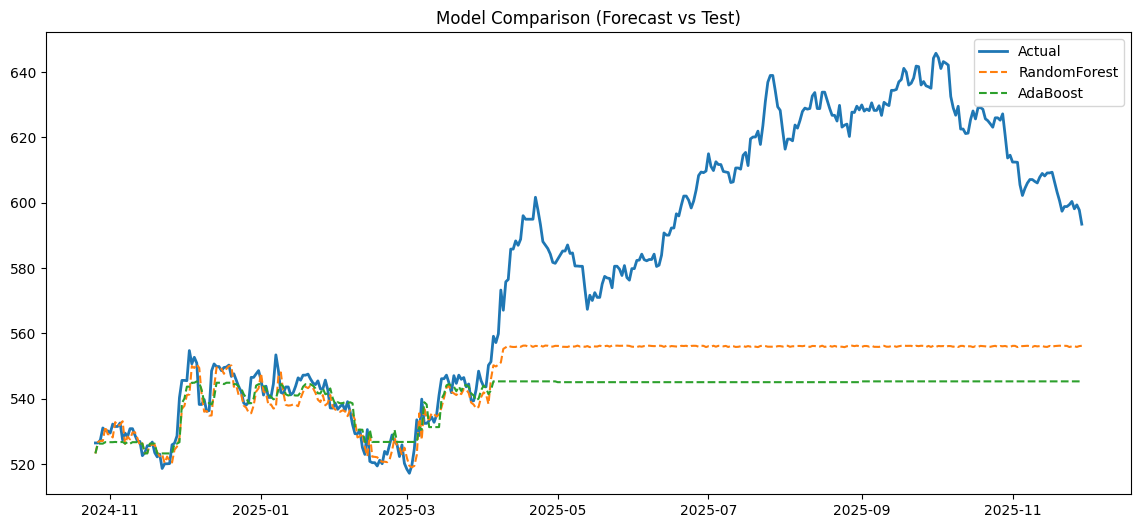

In [27]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)

for name, model in models.items():
    preds = model.predict(X_test)
    plt.plot(y_test.index, preds, label=name, linestyle='--')

plt.title("Model Comparison (Forecast vs Test)")
plt.legend()
plt.show()


In [5]:
X_test

,lag_1,lag_2,lag_7,lag_1_diff,lag_2_diff,lag_7_diff,rolling_3,rolling_7,weekday_sin,weekday_cos,month_sin,month_cos
date,,,,,,,,,,,,
2024-10-24,524.394708,523.645324,531.483497,0.749384,0.559115,-0.840142,523.708747,525.820314,0.433884,-0.900969,-0.866025,0.500000
2024-10-25,524.027733,524.394708,530.529739,-0.366975,0.749384,-0.953758,524.022588,524.755205,-0.433884,-0.900969,-0.866025,0.500000
2024-10-26,523.680163,524.027733,523.801362,-0.347570,-0.366975,-6.728377,524.034201,523.776694,-0.974928,-0.222521,-0.866025,0.500000
2024-10-27,526.437831,523.680163,523.801362,2.757668,-0.347570,0.000000,524.715242,524.153333,-0.781831,0.623490,-0.866025,0.500000
2024-10-28,526.437831,526.437831,523.086209,0.000000,2.757668,-0.715153,525.518608,524.529971,0.000000,1.000000,-0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-25,599.455170,598.845550,606.301968,0.609620,0.000000,-3.069780,599.048757,600.686404,0.781831,0.623490,-0.500000,0.866025
2025-11-26,600.415769,599.455170,603.301984,0.960599,0.609620,-2.999984,599.572163,599.845518,0.974928,-0.222521,-0.500000,0.866025
2025-11-27,598.158133,600.415769,600.644697,-2.257636,0.960599,-2.657287,599.343024,599.110682,0.433884,-0.900969,-0.500000,0.866025


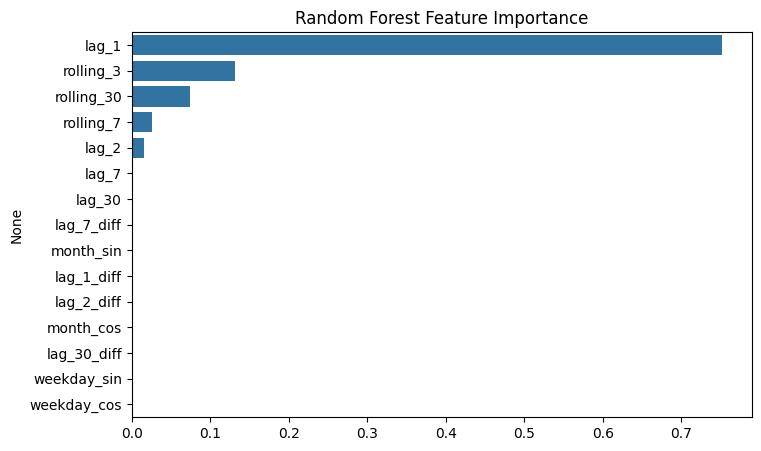

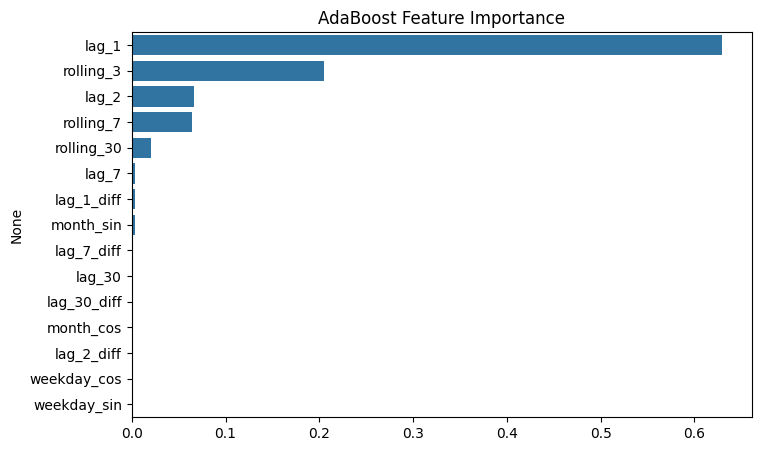

In [28]:
# Random Forest
importances = best_rf.named_steps["rf"].feature_importances_
fi = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Random Forest Feature Importance")
plt.show()

# AdaBoost
importances = best_ada.named_steps["ada"].feature_importances_
fi = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=fi.values, y=fi.index)
plt.title("AdaBoost Feature Importance")
plt.show()
